## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '1d'

# time span of data e.g. 2y for 60m, 10y for 1d
period = '10y'

perc_inc = 0.015 # 1.5 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'IYW' # ITOT iShares TOTAL Market ETF stock

perc_train = 0.12 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = period
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700
2010-06-24,55.380001,55.529999,54.419998,54.580002,49.591793,261600
2010-06-25,54.840000,54.959999,54.070000,54.500000,49.519112,604100


### EDA of Secruity

In [5]:
stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume,percent change
Date,,,,,,,
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700,0.020985
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400,0.013242
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700,0.006069
2010-06-24,55.380001,55.529999,54.419998,54.580002,49.591793,261600,0.014446
2010-06-25,54.840000,54.959999,54.070000,54.500000,49.519112,604100,0.006200


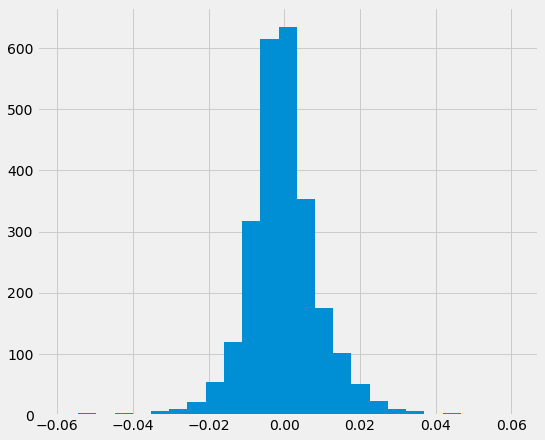

In [6]:
stock_df['percent change'].hist(bins=25);

In [7]:
stock_df['percent change'].quantile([0.84])

0.84    0.007545
Name: percent change, dtype: float64

### Assign Descisions for Up %+ or Not

In [8]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [9]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Date,,,,,,,,
2020-06-01,251.250000,253.449997,250.500000,253.029999,252.591400,102500,-0.007085,0
2020-06-02,253.270004,255.009995,250.339996,255.009995,254.567963,271300,-0.006870,0
2020-06-03,256.140015,257.619995,255.070007,256.730011,256.285004,185300,-0.002303,0
2020-06-04,256.010010,257.730011,253.139999,254.789993,254.348343,409000,0.004766,0
2020-06-05,256.140015,261.140015,255.369995,260.130005,259.679108,130300,-0.015577,1
2020-06-08,259.880005,262.380005,257.750000,262.380005,261.925201,147300,-0.009620,0
2020-06-09,261.109985,264.769989,260.649994,263.739990,263.282837,138300,-0.010072,0
2020-06-10,265.630005,269.420013,264.959991,267.739990,267.275909,116600,-0.007943,0
2020-06-11,261.940002,263.459991,252.509995,252.630005,252.192108,193500,0.035542,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [10]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [11]:
len(decisions)

2518

In [12]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [13]:
len(decisions)

2517

In [14]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(2517, 8)

In [15]:
stock_df_one_off.iloc[-1]

Open                263.690002
High                265.320007
Low                 263.000000
Close               265.190002
Adj Close           265.190002
Volume            56300.000000
percent change       -0.005688
decision              0.000000
Name: 2020-06-18 00:00:00, dtype: float64

In [16]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Date,,,,,,,,
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700,0.020985,0
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400,0.013242,0
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700,0.006069,0
2010-06-24,55.380001,55.529999,54.419998,54.580002,49.591793,261600,0.014446,0
2010-06-25,54.840000,54.959999,54.070000,54.500000,49.519112,604100,0.006200,0


In [17]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    2394
1     123
Name: decision, dtype: int64

### Balance the 0's and 1's

In [18]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

123

In [19]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [20]:
stock_df_bal.shape

(246, 8)

In [21]:
stock_df_bal.decision.value_counts()

1    123
0    123
Name: decision, dtype: int64

### Check for NaN's

In [22]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

In [23]:
stock_df_bal.dropna(axis=0, inplace=True)

In [24]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

### Train Test Split

In [25]:
X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [28]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.6049679487179487

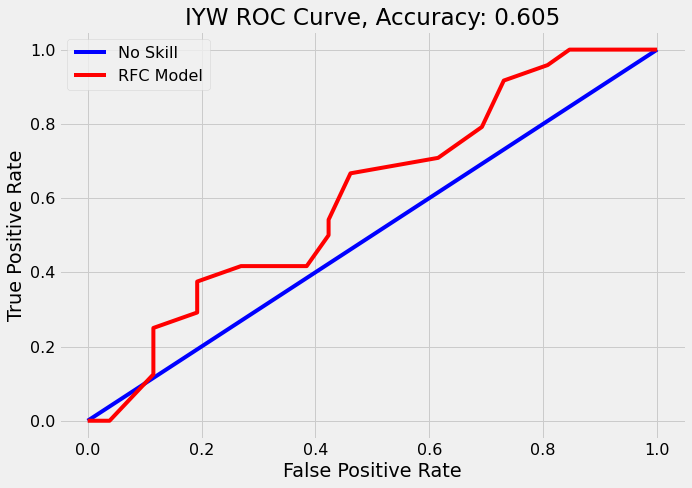

In [29]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished


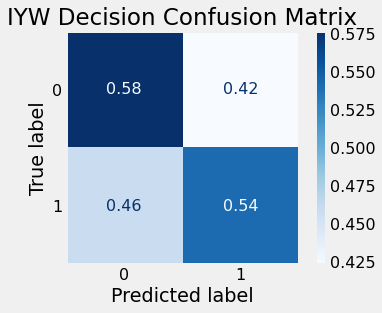

In [30]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                             , X_test
                             , y_test
                             , cmap=plt.cm.Blues
                             , normalize='true'
                            )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

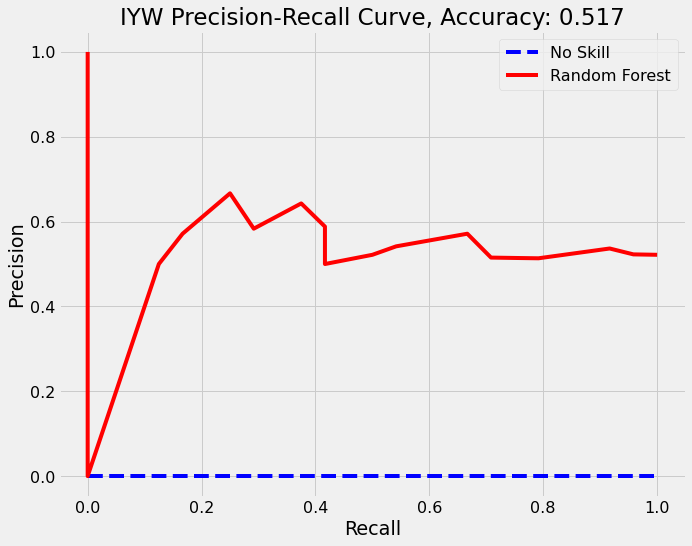

In [31]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [32]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
0,Open,0.202190
5,Volume,0.200122
1,High,0.161747
2,Low,0.161314
3,Close,0.141395
4,Adj Close,0.133233


In [33]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
0,101.669998,102.489998,100.839996,102.239998,96.826332,1935500,-0.005606,0
1,75.900002,76.650002,74.739998,75.180000,68.981697,182200,0.009486,0
2,121.970001,123.099998,121.800003,122.690002,118.626648,148100,-0.005903,0
3,53.939999,54.299999,53.730000,54.259998,49.301037,528800,-0.005933,0
4,89.320000,89.550003,89.139999,89.389999,83.655846,148700,-0.000784,0


### Make A Prediction

In [34]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open            268.450012
High            268.450012
Low             262.630005
Close           264.230011
Adj Close       264.230011
Volume       116900.000000
Name: 2020-06-19 00:00:00, dtype: float64

In [35]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Buy IYW on the 1d interval for 1.5% increase.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
